In [1]:
import pyro
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.distributions as dist
from pyro.poutine import trace, condition

from pyro.infer import MCMC, NUTS, HMC
from utils import samples_to_df, df_to_samples, plot_ESS, plot_GR, plot_posterior

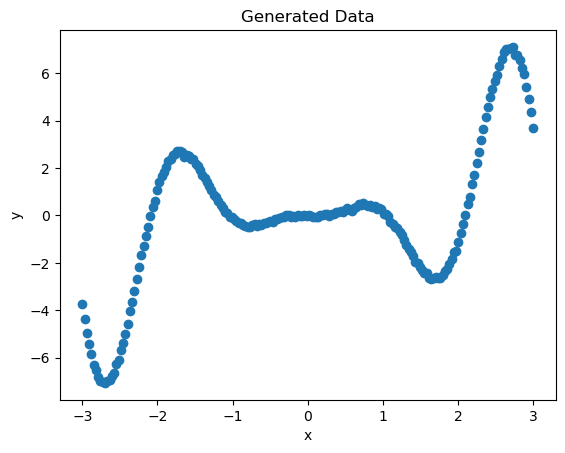

In [2]:
def generate_data(N, D_X, sigma, N_test):
    X = torch.linspace(-3, 3, N)
    X = X[:,None] ** torch.arange(D_X).float()

    Y = X[:,1] ** 2.0 * np.sin(3.0 * X[:,1])
    Y = Y + torch.randn(N) * sigma

    X_test = torch.linspace(-4, 4, N_test)
    X_test = X_test[:,None] ** torch.arange(D_X).float()

    return X, Y, X_test

num_warmup = 20
num_samples = 20
num_chains = 1
N, N_test, sigma, D_X, D_H = 200, 1000, 0.05, 2, 5
X, Y, X_test = generate_data(N, D_X, sigma, N_test)

plt.scatter(X[:,1], Y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Generated Data")
plt.show()

In [3]:
def model_noncentered(X, Y, D_H):
    N, D_X = X.shape
    inv_sigma = pyro.sample("inv_sigma", dist.Gamma(3.0, 1.0))
    sigma = pyro.deterministic("sigma", 1 / inv_sigma)

    W_1 = pyro.sample("W_1", dist.Normal(0, 1).expand((D_X, D_H)).to_event(2))
    W_2 = pyro.sample("W_2", dist.Normal(0, 1).expand((D_H, D_H)).to_event(2))
    W_3 = pyro.sample("W_3", dist.Normal(0, 1).expand((D_H,)).to_event(1))

    Z_1 = torch.tanh(X @ W_1)
    Z_2 = torch.tanh(Z_1 @ W_2)
    Z_3 = Z_2 @ W_3

    pyro.sample("Y", dist.Normal(Z_3, sigma), obs=Y)

def model_centered(X, Y, D_H):
    N, D_X = X.shape
    inv_sigma = pyro.sample("inv_sigma", dist.Gamma(3.0, 1.0))
    sigma = pyro.deterministic("sigma", 1 / inv_sigma)
    X = X.permute(tuple(range(1, X.ndim)) + (0,)) # X.shape == (D_X, N)

    X_scale = X[:D_X, :D_X].clone() # X_scale.shape == (D_X, D_X)
    X_scale = X_scale / (torch.det(X_scale).abs() ** (1 / D_X))
    X_unit = torch.linalg.inv(X_scale) @ X # X_unit.shape == (D_X, N)
    W_1 = pyro.sample("W_1", dist.MultivariateNormal(torch.zeros(D_X), X_scale.T @ X_scale).expand((D_H,)).to_event(1)) # W_1.shape == (D_H, D_X)
    Z_1 = torch.tanh(W_1 @ X_unit) # Z_1.shape == (D_H, N)

    Z_1_scale = Z_1[..., :D_H, :D_H].clone() # Z_1_scale.shape == (D_H, D_H)
    Z_1_scale = Z_1_scale / (torch.det(Z_1_scale).abs() ** (1 / D_H))
    Z_1_unit = torch.linalg.inv(Z_1_scale) @ Z_1 # Z_1_unit.shape == (D_H, N)
    W_2 = pyro.sample("W_2", dist.MultivariateNormal(torch.zeros(D_H), Z_1_scale.T @ Z_1_scale).expand((D_H,)).to_event(1)) # W_2.shape == (D_H, D_H)
    Z_2 = torch.tanh(W_2 @ Z_1_unit) # Z_2.shape == (D_H, N)

    Z_2_scale = Z_2[..., :D_H, :D_H].clone() # Z_2_scale.shape == (D_H, D_H)
    Z_2_scale = Z_2_scale / (torch.det(Z_2_scale).abs() ** (1 / D_H))
    Z_2_unit = torch.linalg.inv(Z_2_scale) @ Z_2 # Z_2_unit.shape == (D_H, N)
    W_3 = pyro.sample("W_3", dist.MultivariateNormal(torch.zeros(D_H), Z_2_scale.T @ Z_2_scale)) # W_3.shape == (D_H,)
    Z_3 = W_3 @ Z_2_unit # Z_3.shape == (N,)

    pyro.sample("Y", dist.Normal(Z_3, sigma), obs=Y)

In [18]:
kernel = NUTS(model_centered)
mcmc = MCMC(kernel, warmup_steps=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc.run(X, Y, D_H)
mcmc.summary()
samples = mcmc.get_samples()
df = samples_to_df(samples)
df.to_csv("bnn.csv")

Sample: 100%|██████████| 40/40 [02:11,  3.28s/it, step size=9.77e-07, acc. prob=0.052]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   W_1[0,0]      0.78      0.00      0.78      0.78      0.78       nan       nan
   W_1[0,1]      1.25      0.00      1.25      1.25      1.25       nan       nan
   W_1[1,0]     -1.27      0.00     -1.27     -1.27     -1.27       nan       nan
   W_1[1,1]      1.39      0.00      1.39      1.39      1.39       nan       nan
   W_1[2,0]      0.05      0.00      0.05      0.05      0.05       nan      1.11
   W_1[2,1]     -1.91      0.00     -1.91     -1.91     -1.91       nan       nan
   W_1[3,0]      0.87      0.00      0.87      0.87      0.87       nan       nan
   W_1[3,1]      0.96      0.00      0.96      0.96      0.96       nan       nan
   W_1[4,0]     -1.65      0.00     -1.65     -1.65     -1.65       nan       nan
   W_1[4,1]      0.32      0.00      0.32      0.32      0.32       nan       nan
   W_2[0,0]      1.03      0.00      1.03      1.03      1.03       nan       nan
   W_2[0,1]    

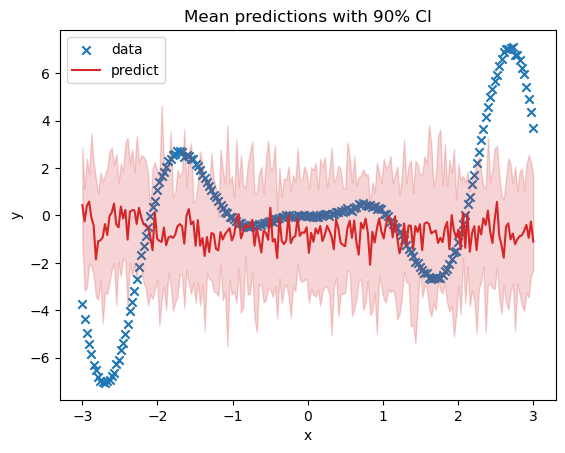

In [19]:
df = pd.read_csv("bnn.csv")
# samples = df_to_samples(df, params=["W_1", "W_2", "W_3", "inv_sigma"], shapes=[(D_X, D_H), (D_H, D_H), (D_H,), ()])
samples = df_to_samples(df, params=["W_1", "W_2", "W_3", "inv_sigma"], shapes=[(D_H, D_X), (D_H, D_H), (D_H,), ()])
predictions = []
for i in range(num_chains * num_samples):
    samples_ = {k: torch.Tensor(v)[i] for k, v in samples.items()}
    predictions.append(trace(condition(model_centered, samples_)).get_trace(X, None, D_H).nodes["Y"]["value"])
predictions = torch.stack(predictions)


mid_prediction = np.median(predictions, axis=0)
low_prediction = np.percentile(predictions, 5.0, axis=0)
high_prediction = np.percentile(predictions, 95.0, axis=0)

plt.scatter(X[:,1], Y, marker="x", color="tab:blue", label="data")
plt.plot(X[:,1], mid_prediction, color="tab:red", label="predict")
plt.fill_between(X[:,1], low_prediction, high_prediction, color="tab:red", alpha=0.2)
plt.title("Mean predictions with 90% CI")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()